In [1]:
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

In [2]:
import csv
with open('EECS_Abstracts.csv','r') as file:
    reader = csv.reader(file)
    lib = list(reader)

In [3]:
filtered_lib = []
for abstract in lib[0]:
    word_tokens = tokenizer.tokenize(abstract)
    filtered_abstract = [w for w in word_tokens if not w in stop_words]
    stemmed = [porter.stem(word).lower() for word in filtered_abstract]
    filtered_lib.append(stemmed)

In [9]:
corpus = set()

In [13]:
for each in filtered_lib:
    each = set(each)
    for word in each:
        corpus.add(word)

In [17]:
corpus = list(corpus)

In [16]:
from nmf_helpers import build_text_vectorizer, hand_label_topics, analyze_article
from my_nmf import NMF

In [28]:
lib[0]

['Purpose: To improve the image quality of highly accelerated multi-channel MRI data by learning a joint variational network that reconstructs multiple clinical contrasts jointly.\n  Methods: Data from our multi-contrast acquisition was embedded into the variational network architecture where shared anatomical information is exchanged by mixing the input contrasts. Complementary k-space sampling across imaging contrasts and Bunch-Phase/Wave-Encoding were used for data acquisition to improve the reconstruction at high accelerations. At 3T, our joint variational network approach across T1w, T2w and T2-FLAIR-weighted brain scans was tested for retrospective under-sampling at R=6 (2D) and R=4x4 (3D) acceleration. Prospective acceleration was also performed for 3D data where the combined acquisition time for whole brain coverage at 1 mm isotropic resolution across three contrasts was less than three minutes.\n  Results: Across all test datasets, our joint multi-contrast network better prese

In [31]:
vectorizer, vocabulary = build_text_vectorizer(lib[0],
                             use_tfidf=True,
                             use_stemmer=False,
                             max_features=5000)
X = vectorizer(lib[0])

In [33]:
X.shape

(5356, 5000)

In [35]:
import numpy as np

In [38]:
# We'd like to see consistent results, so set the seed.
np.random.seed(12345)

# Find latent topics using our NMF model.
factorizer = NMF(k=5, max_iters=5, alpha=0.5)
W, H = factorizer.fit(X, verbose=True)

iter 0 : reconstruction error: 281.76855579300764
iter 1 : reconstruction error: 100.07106578083967
iter 2 : reconstruction error: 74.88950460132432
iter 3 : reconstruction error: 72.42671194695552
iter 4 : reconstruction error: 71.4710270321863
FINAL reconstruction error: 71.13234822441217 



In [39]:
# Label topics and analyze a few NYT articles.
hand_labels = hand_label_topics(H, vocabulary)

topic 0
--> n 1 2 p mass 3 4 10 5 ψ mathrm e c 0 times j pm0 rm gev cross
please label this topic: numbers

topic 1
--> 0 pm π b k cp decay decays overline rightarrow lhcb fb integrated proton 1 mathcal rm branching luminosity 7
please label this topic: lol

topic 2
--> gravitational wave ligo galaxies data noise dark search matter sources optical frequency survey waves high advanced energy z hz detectors
please label this topic: space

topic 3
--> model method learning methods objects task dune based models optimization neutrino performance propose physics matrix graph system approach design 3d
please label this topic: modeling

topic 4
--> network n algorithms problem algorithm quantum networks show learning graph channel time coding data optimal models bounds model number log
please label this topic: networking



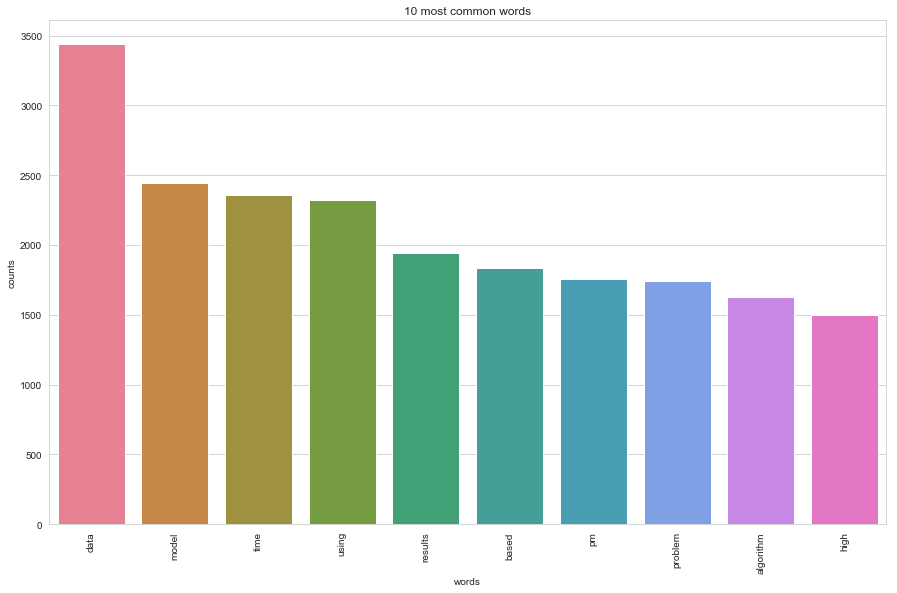

In [41]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(lib[0])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [43]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 15
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
pm mass decay data mathrm using decays rm mathcal lhcb integrated measured 10 proton rightarrow

Topic #1:
problem algorithm time algorithms model graph number problems optimal results network paper linear log bounds

Topic #2:
galaxies galaxy star mass redshift sample games stellar formation game 10 gas high evolution cluster

Topic #3:
data quantum model based learning state performance using systems network models high demonstrate new approach

Topic #4:
data gravitational energy wave high 10 using search ray mass results stars signal frequency survey


In [52]:
import os 
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
with open(LDAvis_data_filepath, 'w') as f:
    pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

KeyboardInterrupt: 